# Use Amazon SageMaker XGBoost model locally
Amazon SageMaker provides a built-in implementation of the open source XGBoost algorithm
for a wide variety of regression and classification problems with the following benefits:

- SageMaker's training service provides scalable distributed XGBoost training on large scale datasets without having to manage your own infrastructure.
- SageMaker's automatic model tuning of XGBoost models can efficiently determine the best set of hyperparameters for the model.
- SageMaker hosting of resulting XGBoost models are available with one-click deployment for scalable predictions.

Customers using XGBoost with SageMaker would like the best of both worlds. They would like
the benefits above, but they also want seamless model evaluation during their iterative
model building process. They need easy access to XGBoost feature importance to understand
what features are contributing most heavily to the resulting predictions. They also want to 
produce ROC curves to visualize model performance. Lastly, they'd like to perform predictions
using test data without the need to wait minutes for a hosted endpoint to become active on
their latest trained model.

Fortunately, as part of the model artifacts produced by SageMaker, customers can achieve
all of this, and this notebook demonstrates how to do so.

## Getting started
This notebook assumes you have already trained an XGBoost model using SageMaker. Here you
simply enter the name of your training job. You can get this name from the SageMaker
console, the CLI, or from the Estimator object in your notebook using the Python SDK.

In [108]:
TRAINING_JOB_NAME = 'xgboost-2019-07-24-19-59-26-003'

In [109]:
local_artifacts_filename = 'tmp.tar.gz'

## Define a function to download the model artifacts
This function downloads the SageMaker model artifacts file given the name
of a SageMaker training job. The model artifacts file is a compressed tar file.
For an XGBoost trained model, this compressed file contains the actual XGBoost
model which can be used just as you would use any XGBoost model.

In [110]:
import re
import boto3

def download_artifacts(job_name, local_fname):
    sm_client = boto3.client('sagemaker')
    response = sm_client.describe_training_job(TrainingJobName=TRAINING_JOB_NAME)
    model_artifacts_full_path = response['ModelArtifacts']['S3ModelArtifacts']  
    
    p = re.compile('(?<=s3://).*?/')
    s = p.search(model_artifacts_full_path)
    object_name_start = s.span()[1]
    object_name = model_artifacts_full_path[object_name_start:]
    bucket_name = s.group()[:-1]
    s3 = boto3.client('s3')
    s3.download_file(bucket_name, object_name, local_fname)

## Define a function to extract the XGBoost model
This function extracts the native XGBoost model from a model artifacts file.
You can then use the model to do things like make predictions, plot feature
importance, or even visualize model performance with an ROC curve.

In [111]:
import tarfile
import joblib

def unpack_model_file(fn):
    ## Unpack model file

    tar = tarfile.open(fn, 'r:gz')
    for member in tar.getmembers():
         f = tar.extractfile(member)
         if f is not None:
             content = f.read()
    tar.extractall()
    fil = open('xgboost-model', 'rb')

    ## Load model file back into generate predictions & view feature importance

    return joblib.load(fil)

    ## Close

    fil.close()

## Download and unpack the XGBoost model

In [112]:
download_artifacts(TRAINING_JOB_NAME, local_artifacts_filename)

In [113]:
local_model = unpack_model_file(local_artifacts_filename)

[11:52:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [114]:
!ls -l xgboost-model
!ls -l $local_artifacts_filename

-rw-r--r-- 1 ec2-user ec2-user 1264702 Jul 24 20:02 xgboost-model
-rw-rw-r-- 1 ec2-user ec2-user 568675 Jul 25 11:52 tmp.tar.gz


## Exercise the model locally
Here we get to the real purpose of this notebook. The XGBoost trained model from SageMaker
is available locally, and we demonstrate that it works. First we chart feature importance.

In [115]:
num_features = len(local_model.feature_names)

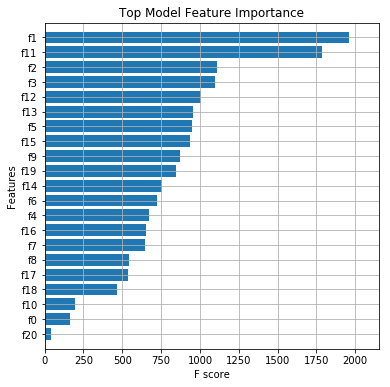

In [116]:
## Chart variable importance
import xgboost as xgb
import matplotlib.pyplot as plt  

fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(local_model, max_num_features=num_features, 
                    height=0.8, ax=ax, show_values = False)
plt.title('Top Model Feature Importance')
plt.show()

## Make some local predictions
Here we make local predictions using the XGBoost model. Since we have no idea
what model you built, we just generate a random set of input features based on the
number of features in your model. No SageMaker endpoint was created. Note that this
is great for local iterations during development, but for production usage, you would
then be able to leverage SageMaker hosting to surface scalable inference to all of your
client applications.

In [117]:
import numpy as np
random_prediction_input = np.random.rand(num_features)
random_prediction_input

array([0.88909005, 0.47002169, 0.70422999, 0.85942743, 0.22072083,
       0.78182814, 0.62474307, 0.14677621, 0.65826772, 0.97617562,
       0.54798363, 0.14322313, 0.92073321, 0.95842204, 0.58878439,
       0.76251763, 0.91288893, 0.21210937, 0.44511446, 0.07359886,
       0.04104192])

In [118]:
local_model.predict(xgb.DMatrix([random_prediction_input]))

array([4.319355], dtype=float32)